In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Display 'Measurement' row's columns and data in dictionary format
first_row_Measurement = session.query(Measurement).first()
first_row_Measurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1f2c8de64a8>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [11]:
# Display 'Station' row's columns and data in dictionary format 
first_row_Station = session.query(Station).first()
first_row_Station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1f2c8de6b38>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716}

In [12]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [13]:
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [14]:
# Using the inspector to print the column names within the 'Measurement' table and its types
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [15]:
# Using the inspector to print the column names within the 'Station' table and its types
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [16]:
# Find the most recent date in the data set.
engine.execute('SELECT MAX(date) FROM measurement').fetchall()

[('2017-08-23',)]

In [17]:
# Latest Date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(latest_date)

('2017-08-23',)


Last date in data set: 2016-08-23


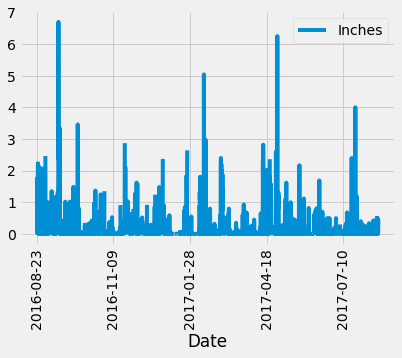

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print("Last date in data set:", year_ago)

# Perform a query to retrieve the data and precipitation scores
data_query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.date<= dt.date(2017,8,23)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(data_query,columns=['Date', 'Inches'])

# Sort the dataframe by date
df = df.sort_values(by='Date')

# create bar chart
df.plot(x='Date',y='Inches', rot=90)

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()


,Inches
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [24]:
# Design a query to calculate the total number stations in the dataset
stations_query = session.query(func.count(Station.station)).all()

In [25]:
#station names query
names_query = session.query(Measurement.station).\
     group_by(Measurement.station).\
     order_by((Measurement.station).desc()).all() 
names_query

[('USC00519523'),
 ('USC00519397'),
 ('USC00519281'),
 ('USC00518838'),
 ('USC00517948'),
 ('USC00516128'),
 ('USC00514830'),
 ('USC00513117'),
 ('USC00511918')]

In [26]:
names1_query = session.query(Station.station).all()
names1_query

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [27]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_station_query = session.query(func.count(Measurement.station)).\
     group_by(Measurement.station).\
     order_by(Measurement.station).all() 
active_station_query
active_station_query.sort(reverse=True)
print(active_station_query)

[(2772,), (2724,), (2709,), (2669,), (2612,), (2202,), (1979,), (1372,), (511,)]


In [28]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_station_query = session.query(Measurement.station,func.count(Measurement.station)).\
     group_by(Measurement.station).\
     order_by(func.count(Measurement.station).desc()).all() 
active_station_query


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [29]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station= active_station_query[0]
most_active_station
avg_temp = session.query(Station.id, Station.name, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
   filter(Measurement.station == Station.station).\
   filter(Measurement.station == active_station_query[0][0]).all()
avg_temp


[(7, 'WAIHEE 837.5, HI US', 54.0, 85.0, 71.66378066378067)]

In [30]:
# most active station
active_station_query[0][0]

'USC00519281'

In [33]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#temps_query = session.query(Measurement.date,Measurement.tobs).\
temps_query = session.query(Measurement.tobs).\
    filter(Measurement.station==active_station_query[0][0]).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.date<= dt.date(2017,8,23)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
temps_df = pd.DataFrame(temps_query,columns=['Temp'])


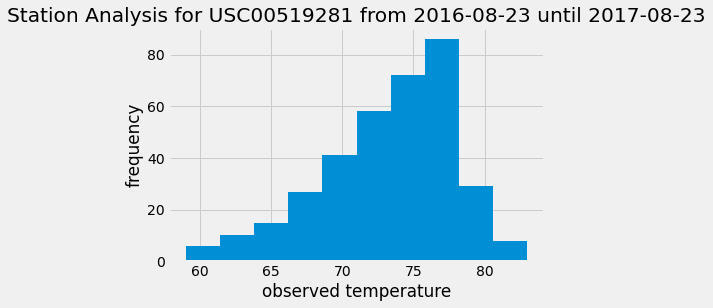

In [34]:
# histogram plot
plt.hist(temps_df['Temp'],bins=10)
plt.ylabel("frequency")
plt.xlabel("observed temperature")
plt.title(f"Station Analysis for {active_station_query[0][0]} from {year_ago} until 2017-08-23")
plt.show()

# Close session

In [ ]:
# Close Session
session.close()